# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

Wall time: 0 ns


# Overview

We illustrate the numerical implementation and the use of the active Finite Time Lyapunov Exponent (aFTLE) on 2-D homogeneous, isotropic turbulence. The active LCS diagnostic is applied to the two-dimensional and steady Lagrangian vorticity barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active Finite Time Lyapunov Exponent (aFTLE) to Lagrangian vorticity barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Lagrangian barrier equation for vorticity is an autonomous Hamiltonian system of the form:
    
    \begin{equation}
    \mathbf{x}_0'= \dfrac{\nu}{t_1-t_0} \mathbf{J} \nabla \delta \mathbf{\omega (\mathbf{x}_0, t_0,t_1)},
    \label{eq: vorticity},
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aFTLE is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the FTLE, which is fundamentally limited by the spatial and temporal domain of the available data.
    
    <br />
    
   * First we compute the trajectories over the time-interval [0, 25] over the selected domain. We then compute the right-hand-side of equation \ref{eq: vorticity} by interpolating $ \mathbf{J} \mathbf{\nabla_0 \overline{\omega (\mathbf{F_{t_0}^{t}(x_0)}, t)}} $, where $ \overline{(\ldots)} $ denotes a temporal average.
   
   <br />
   
   * We then apply the aFTLE to the autonomous ODE from equation \ref{eq: vorticity} over different 'dummy' time-intervals. We additionally compare the results with the classic FTLE-field.

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

Wall time: 35.8 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 16

# time-interval over which data is defined. DO NOT CHANGE!!!
time_data = np.linspace(0, 50, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size
dt = .2

# Time resolution: N = len(time)
time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# domain boundary (in degrees)
xmin = 3
xmax = 5
ymin = 1
ymax = 3

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and t0 >= np.min(time_data) and tN <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.005
dy = 0.005

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.002
sN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, sN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

Wall time: 2 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

Wall time: 38.8 s


# Compute trajectories

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import funciton to compute trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import package for parallel computing
from joblib import Parallel, delayed

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into 'Ncores' batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]
    
    return Fmap

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract FTLE field from results of parallel computing
Fmap = results[0]

for res in results[1:]:
    Fmap = np.append(Fmap, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   32.8s remaining:  3.8min
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:   33.5s remaining:  2.4min
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:   33.5s remaining:  1.7min
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:   35.0s remaining:  1.3min
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:   35.1s remaining:   58.6s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:   36.8s remaining:   47.3s
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:   37.2s remaining:   37.2s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:   37.3s remaining:   29.0s
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:   38.0s remaining:   22.7s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:   38.2s remaining:   17.3s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapse

# Lagrangian vorticity barriers

We visualize Lagrangian vorticity barriers by applying the FTLE-field to the trajectories of system \ref{eq: vorticity}. As soon as the FTLE-field is applied to an active vector field, such as vorticity, we refer to it as aFTLE (active FTLE). We will subsequently compare the results with the classic version of the FTLE-field.

## Interpolate Lagrangian vorticity barrier field

We start by computing the interpolant for the Lagrangian vorticity barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: vorticity}.

In [7]:
%%time
# Import interpolation function for Lagrangian vorticity barrier equation
from ipynb.fs.defs.LagrangianActiveVorticity import LagrangianActiveVorticity

# Interpolate RHS of vorticity barrier equation using cubic spatial interpolation
Interpolant_vorticity = LagrangianActiveVorticity(X_domain, Y_domain, X, Y, omega, Fmap, time, dt_data, aux_grid)

Wall time: 3.69 s


## Compute trajectories from barrier equation

In the following we compute trajectories over a meshgrid. The integration is vectorized by arranging the initial conditions to a vector. As we need to compute the gradient of the flow map, we seed around each initial condition four particles on an auxiliary meshgrid. For each initial condition we hence have in total 5 particle trajectories (four auxiliary trajectories+original trajectory).

In [8]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.RK4_integration import RK4_integration

# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for parallel computing
from joblib import Parallel, delayed

# initial conditions of auxiliary grid
x0_init, y0_init = X_domain.ravel(), Y_domain.ravel()
x0_init_R = x0_init + aux_grid[0]
x0_init_L = x0_init - aux_grid[0]
y0_init_U = y0_init + aux_grid[1]
y0_init_D = y0_init - aux_grid[1]

# create array which stores solution of particle trajectories
solODE = np.zeros((len(s_dummy), 2, len(x0_init), 5))
        
Interpolant_vorticity_x = Interpolant_vorticity[0]
Interpolant_vorticity_y = Interpolant_vorticity[1]
ds = s_dummy[1]-s_dummy[0]

# initial conditions of auxiliary grid
r0 = np.array([x0_init, y0_init]) # shape (len(x0_init), 2)
r0R = np.array([x0_init_R, y0_init]) # shape (len(x0_init), 2)
r0L = np.array([x0_init_L, y0_init]) # shape (len(x0_init), 2)
r0U = np.array([x0_init, y0_init_U]) # shape (len(x0_init), 2)
r0D = np.array([x0_init, y0_init_D]) # shape (len(x0_init), 2)

# solODE stores trajectories launched from auxiliary grid
solODE[0,:,:,0] = r0
solODE[0,:,:,1] = r0R
solODE[0,:,:,2] = r0L
solODE[0,:,:,3] = r0U
solODE[0,:,:,4] = r0D

# iterate over all trajectories from auxiliary grid (this is parallellized)
def trajectories_auxiliary_grid(solODE):
    
    solODE_parallel = solODE.copy()
    
    # iterate over dummy time
    for i in range(len(s_dummy)-1):
        solODE_parallel[i+1,:,:] = RK4_integration(solODE_parallel[i,:,:], ds, Interpolant_vorticity[0], Interpolant_vorticity[1])[0]
    
    return solODE_parallel

# compute trajectories over meshgrid
solODE = np.array(Parallel(n_jobs=5, verbose = 0)(delayed(trajectories_auxiliary_grid)(solODE[:,:,:,i]) for i in range(5)))
solODE= np.transpose(solODE, (1, 2, 3, 0))

Wall time: 1min 3s


## Compute active FTLE

We now compute the active FTLE for the Lagrangian vorticity barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: vorticity}. Finally, we apply the classic FTLE to the active Cauchy-Green strain tensor.

In [9]:
# Import function to compute Finite-Time Lyapunov Exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# compute aFTLE
aFTLE = [[], [], []]

s1 = 0.05
s2 = 0.15
s3 = 0.25

s = [0.05, 0.15, 0.25]

for i in range(solODE.shape[2]):
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
    
        xR = solODE[idx,0,i,1]
        xL = solODE[idx,0,i,2]
        yR = solODE[idx,1,i,1]
        yL = solODE[idx,1,i,2]
    
        xU = solODE[idx,0,i,3]
        xD = solODE[idx,0,i,4]
        yU = solODE[idx,1,i,3]
        yD = solODE[idx,1,i,4]
    
        gradFmap = np.zeros((2,2))*np.nan
    
        gradFmap[0,0] = (xR-xL)/(2*aux_grid[0])
        gradFmap[0,1] = (xU-xD)/(2*aux_grid[1])
        gradFmap[1,0] = (yR-yL)/(2*aux_grid[0])
        gradFmap[1,1] = (yU-yD)/(2*aux_grid[1])
    
        # aFTLE at over [0,s1]
        aFTLE[counter].append(_FTLE(gradFmap, s_dummy[idx]))
        
        counter += 1

# Classic Finite-Time Lyapunov Exponent (FTLE)

Next, we compute the FTLE over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ \left[\dfrac{1}{100}, \dfrac{1}{5}\right] $. Subsequently, we compute the Cauchy Green strain tensor. From the maximum eigenvalue of the Cauchy-Green strain tensor we can then compute the FTLE. The iteration over the meshgrid is parallelized.

In [10]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute trajectories (=flow map)
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

def parallel_FTLE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, Nx*Ny, 2, 2)

    # extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # shape (N, 2, 2, Nx*Ny)

    # compute FTLE
    FTLE = []
    for i in range(gradFmap_t0_tN.shape[2]):
        FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))
    
    return FTLE

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_FTLE)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract FTLE field from results of parallel computing
FTLE = results[0]

for res in results[1:]:
    FTLE = np.append(FTLE, res)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
FTLE = FTLE.reshape((X_domain.shape[0], X_domain.shape[1]))

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:  2.2min remaining: 15.2min
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:  2.2min remaining:  9.5min
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:  2.2min remaining:  6.6min
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:  2.2min remaining:  4.8min
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:  2.2min remaining:  3.7min
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:  2.3min remaining:  2.9min
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:  2.3min remaining:  1.4min
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapse

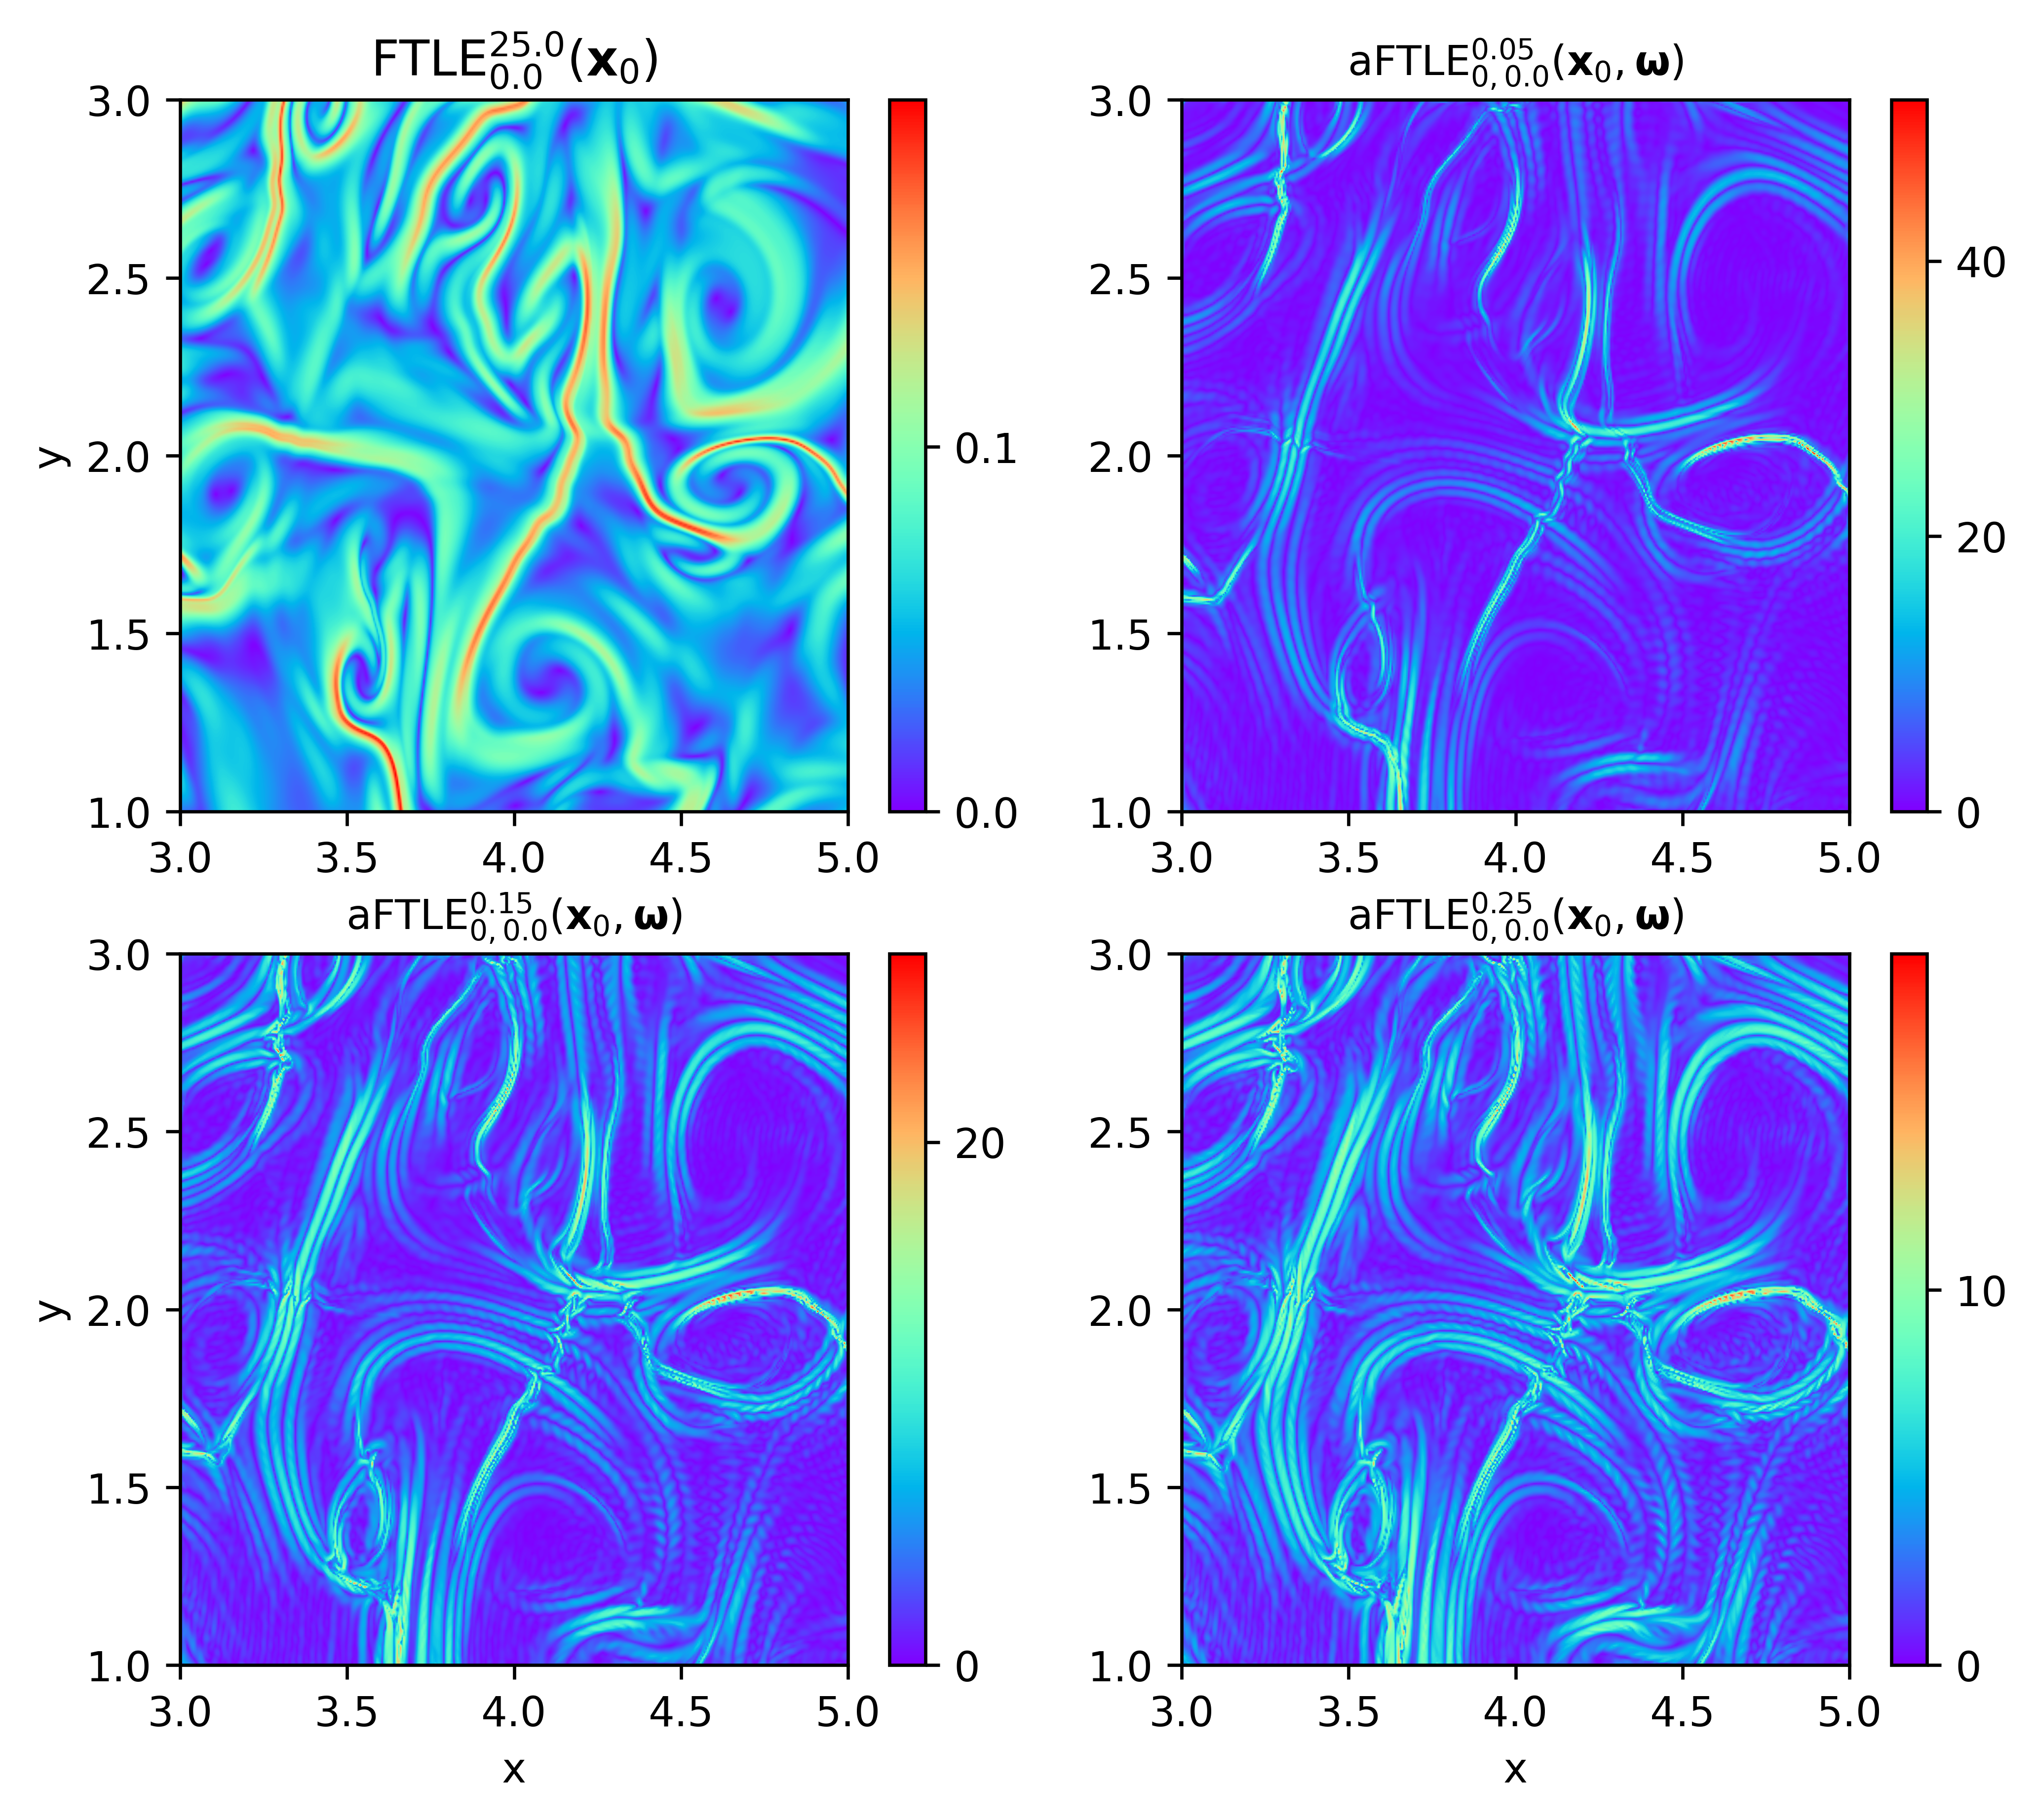

In [11]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

# Contourplot of classic FTLE over the time-interval [0,25] over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, FTLE, cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 0.4, 5))

# Contourplot of aFTLE_0^0.05 over meshgrid of initial conditions
cax = ax1.tricontourf(x0_init, y0_init, aFTLE[0], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.15 over meshgrid of initial conditions
cax = ax2.tricontourf(x0_init, y0_init, aFTLE[1], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 100, 6))

# Contourplot of aFTLE_0^0.25 over meshgrid of initial conditions
cax = ax3.tricontourf(x0_init, y0_init, aFTLE[2], cmap = "rainbow", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.linspace(0, 50, 6))

# Axis Labels
ax2.set_ylabel("y", fontsize = 10)
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)

# Axis ticks
ax0.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax1.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax2.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax3.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+.1, 0.5))
ax0.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax1.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax2.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))
ax3.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+.1, 0.5))

ax0.set_title(r'$\mathrm{FTLE}$'+f'$_{{{np.around(time[0], 2)}}}^{{{np.around(time[-1], 2)}}}$'+r'($ \mathbf{x}_0 $)')
ax1.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[0])], 2)}}}$'+r'($ \mathbf{x}_0, \mathbf{\omega}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[1])], 2)}}}$'+r'($ \mathbf{x}_0, \mathbf{\omega}$)', fontsize = 10)
ax3.set_title(r'$ \mathrm{aFTLE}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[np.searchsorted(s_dummy, s[2])], 2)}}}$'+r'($ \mathbf{x}_0, \mathbf{\omega}$)', fontsize = 10)

plt.show()

The figures focus on vorticity-based active barriers in one of the vortical regions of the two-dimensional turbulence model. 
As expected the FTLE has a very weak signature when considering the instantaneous limit. On the other hand, the aFTLE provides a clear picture the main vortex and active hyperbolic barriers. The features become even more pronounced for longer s-times, revealing several secondary vortices around its neighbourhood. None of these vortices are present in the classic instantaneous FTLE. Ridges of the FTLE reveal barriers which block the transport of vorticity.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.7.1. in "Transport Barriers and Coherent Structures in Flow Data" by George Haller.